## 1. Module Import, Select Device, and Download MNIST Data

### 1-1. Setup & Module Import

In [1]:
!pip install qiskit[visualization]

     |████████████████████████████████| 6.0MB 5.4MB/s 
     |████████████████████████████████| 18.0MB 180kB/s 
     |████████████████████████████████| 235kB 33.3MB/s 
     |████████████████████████████████| 215kB 20.5MB/s 
     |████████████████████████████████| 2.1MB 30.4MB/s 
     |████████████████████████████████| 163kB 36.8MB/s 
     |████████████████████████████████| 1.5MB 18.2MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 194kB 37.1MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
     |████████████████████████████████| 614kB 28.2MB/s 
     |████████████████████████████████| 3.2MB 29.4MB/s 
     |████████████████████████████████| 6.3MB 26.6MB/s 
  Created wheel for qiskit: filename=qiskit-0.27.0-cp37-none-any.whl size=10505 sha256=5dc19716b6c9aaf37dbd1dd72a44a104ad6094971d769e85e819280520a48b39
  Stored in directory: /root/.cache/pip/wheels/c6/54/d9/f0f711dc20aff31947456951374132d0e23ec527da8c15295d
  Created wheel fo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# from torchsummary import summary

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit.circuit.random import random_circuit

from itertools import combinations

### 1-2. Select Device

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)
#print('cuda index:', torch.cuda.current_device())
#print('GPU 이름:', torch.cuda.get_device_name())

Using PyTorch version: 1.9.0+cu102  Device: cpu


### 1-3. Setting of the main hyper-parameters of the model

In [4]:
BATCH_SIZE = 256
EPOCHS = 10     # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
seed = 47
np.random.seed(seed)        # Seed for NumPy random number generator
torch.manual_seed(seed)     # Seed for TensorFlow random number generator

### 1-4. Data Loading

In [5]:
train_dataset = datasets.MNIST(root = "./data",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "./data",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([256, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([256]) type: torch.LongTensor


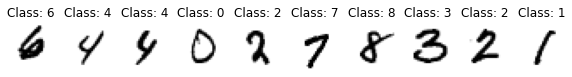

In [ ]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))



## 2. Construct Quantum Circuit

### 2-1. Create a 'Quantum Class' with Qiskit

In [91]:
class RandomCircuit:
    """ 
    This class defines random circuit of Quanvolution layer
    """
                      
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.n_qubits = n_qubits
        self._circuit = qiskit.QuantumCircuit(self.n_qubits)

        depth = np.random.randint(1,7,1)[0]
                                                  
        #self.theta = qiskit.circuit.Parameter('theta')
        self.theta = [qiskit.circuit.Parameter('theta{}'.format(i)) for i in range(self.n_qubits)]

        for i in range(self.n_qubits):                                                                  
            self._circuit.ry(self.theta[i], i)

        self._circuit.barrier()
        self._circuit += random_circuit(self.n_qubits, depth)                                                                                                  
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
                                                                                                                                              
    def run(self, data):
        param_dict = dict()
        for i in range(self.n_qubits):
            param_dict[self.theta[i]] = data[i] * np.pi / 255

        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [param_dict])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
                                                                                                                                                                                                                                                                   
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
                                                                                                                                                                                                                                                                                           
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities) / np.pi
                                                                                                                                                                                                                                                                                                                                   
        return np.array([expectation])

Let's test the implementation.

[309.77281504]


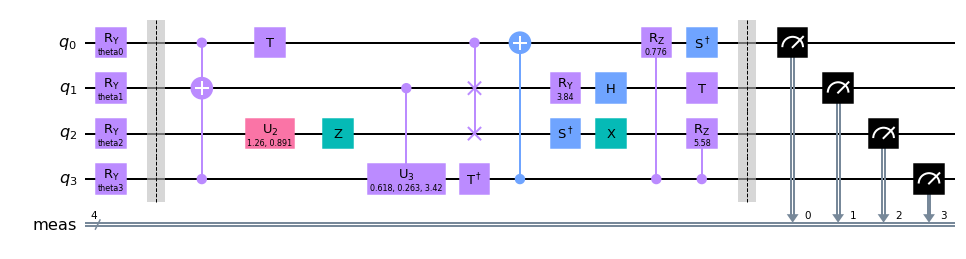

In [101]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = RandomCircuit(4, simulator, 100)
#print('Expected value for rotation pi {}'.format(circuit.run([np.pi, np.pi*2])[0]))
print(circuit.run([128, 64, 15, 251]))
circuit._circuit.draw('mpl')

### 2-2. Create a 'Quanvolution Class' with PyTorch

In [ ]:
# def quanv_feed(image):
#     """
#     Convolves the input image with many applications 
#     of the same quantum circuit.

#     In the standard language of CNN, this would correspond to
#     a convolution with a 5×5 kernel and a stride equal to 1.
#     """
#     out = np.zeros((24, 24, 25))

#     # Loop over the coordinates of the top-left pixel of 5X5 squares
#     for j in range(24):
#         for k in range(24):
#             # Process a squared 5x5 region of the image with a quantum circuit
#             circuit_input = []
#             for a in range(5):
#                 for b in range(5):
#                     circuit_input.append(image[j + a, k + b, 0])
#             q_results = circuit(circuit_input)

#             # Assign expectation values to different channels of the output pixel (j/2, k/2)
#             for c in range(25):
#                 out[24, 24, c] = q_results[c]
#     return out

In [ ]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, inputs, in_channels, out_channels, kernel_size, quantum_circuits, shift):
        """ Forward pass computation """
        # input  shape : (-1, 1, 28, 28)
        # otuput shape : (-1, 6, 24, 24)
        ctx.in_channels      = in_channels
        ctx.out_channels     = out_channels
        ctx.kernel_size      = kernel_size
        ctx.quantum_circuits = quantum_circuits
        ctx.shift            = shift

        _, _, len_x, len_y = inputs.size()
        len_x = len_x - kernel_size + 1
        len_y = len_y - kernel_size + 1
        
        features = []
        for input in inputs:
            feature = []
            for circuit in quantum_circuits:
                xys = []
                for x in range(len_x):
                    ys = []
                    for y in range(len_y):
                        data = input[0, x:x+kernel_size, y:y+kernel_size]
                        ys.append(circuit.run(data))
                    xys.append(ys)
                feature.append(xys)
            features.append(feature)       
        result = torch.tensor(features)

        ctx.save_for_backward(inputs, result)
        return result
        
    @staticmethod
    def backward(ctx, grad_output): # 확인 필요(검증 x)
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None


class Quanv(nn.Module):
    """ Quanvolution(Quantum convolution) layer definition """
    
    def __init__(self, in_channels, out_channels, kernel_size, 
                 backend=qiskit.Aer.get_backend('aer_simulator'), 
                 shots=100, shift=np.pi/2):
        super(Quanv, self).__init__()
        self.quantum_circuits = [QuanvCircuit(kernel_size=kernel_size, 
                                              backend=backend, shots=shots, threshold=127) 
                                 for i in range(out_channels)]
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.kernel_size  = kernel_size
        self.shift        = shift
        
    def forward(self, inputs):
        return QuanvFunction.apply(inputs, self.in_channels, self.out_channels, self.kernel_size,
                                   self.quantum_circuits, self.shift)


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.quanv = Quanv(1, 6, kernel_size=5)
        self.conv = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.quanv(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x)

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculating loss
        loss = loss_func(output, target)
        
        # Backward pass
        loss.backward()
        
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.cuda()
        target = target.cuda()
        output = model(data).cuda()
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = loss_func(output, target)
        total_loss.append(loss.item())
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100 / batch_size)
        )